# **Camera Calibration**
## Image Processing and Computer Vision - Lab Session No. 3

Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

**Camera calibration** → estimation of all parameters of a specific camera device.

For the **pinhole camera model** we have:

$$\textbf{P} = \textbf{A}[\textbf{R}|\textbf{t}]$$

Where:
* Intrinsic parameter matrix $\textbf{A}$;
* Extrinsic parameters:
  * Rotation matrix $\textbf{R}$;
  * Translation vector $\textbf{t}$.

Depending on the application, either the Perspective Projection Matrix $\textbf{P}$ only or also its independent components ($\textbf{A}, \textbf{R}, \textbf{t}$) need to be estimated.

The basic process estimation relies on setting up a linear system of equations given a set of **known 3D-2D correspondences**, so as to then solve for the unknown camera parameters (*see Lab Session No. 2*).

To obtain the required correspondences, specific physical objects (referred to as **calibration targets**) with easily detectable features (such as **chessboard** or dot patterns) are typically deployed.

## Preliminaries

### Pinhole camera model

The general form of the Perspective Projection Matrix  (PPM or $\textbf{P}$) can be thought of as encoding:
* The position of the camera w.r.t. the world into $\textbf{[R|t]}$;
* The characteristics of the sensing device into $\textbf{A}$.

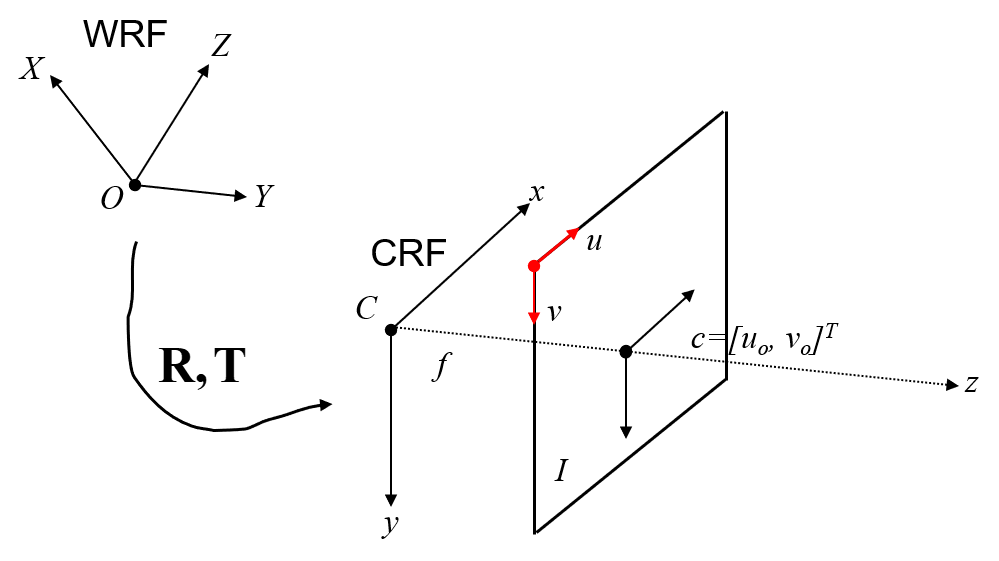

### Intrisic Parameters

Matrix $\textbf{A}$, which models the characteristics of the image sensing device, is called **Intrinsic Parameter Matrix**.

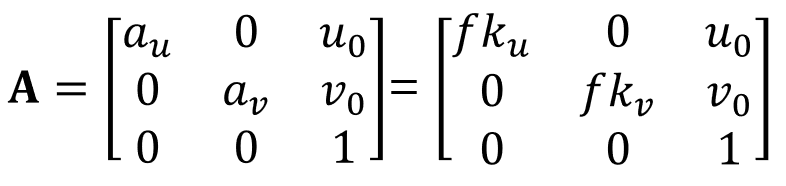

where:

* $f$ is the **focal length** of the pinhole system;
* $k_u, k_v$ are the inverse of the **horizontal and vertical pixel size**, respectively;
* $u_0, v_0$ are the coordinates of the **piercing point** w.r.t. the top-left corner.

**Intrinsic parameters are 5** but can be **reduced** in number by setting $a_u = f*k_u$ and $a_v = f*k_v$, where such quantitites represent the focal length expressed in horizontal and vertical pixel size, respectively.

**The number of intrinsic parameters estimated by OpenCV is thus 4**. The pixel size is usually provided in the camera datasheet: if it is known, the metric focal length can be recovered.

### Extrinsic Parameters

$\textbf{[R|t]}$, which encodes the position and orientation of the camera w.r.t. the WRF, is called **Extrinsic Parameter Matrix**.

Since a **rotation matrix** **(3x3=9 entries)** has indeed only **3 independent parameters (DOF)**, which correspond to the **rotation angles** around the axis of the RF, the **total number of extrinsic parameters is 6** (**3 translation parameters + 3 rotation parameters**).

### World Reference Frame

To ease the derivation and implementation of calibration routines, the **World Reference Frame** is assumed to be **attached to the chessboard**. Therefore, **different calibration images lead to different World Reference Frames**.

In other words, you can perform your calibration by **moving the chessboard** (as depicted on the left picture), and the software will interpret those transformations as if you were **moving the camera** (as depicted on the right picture).

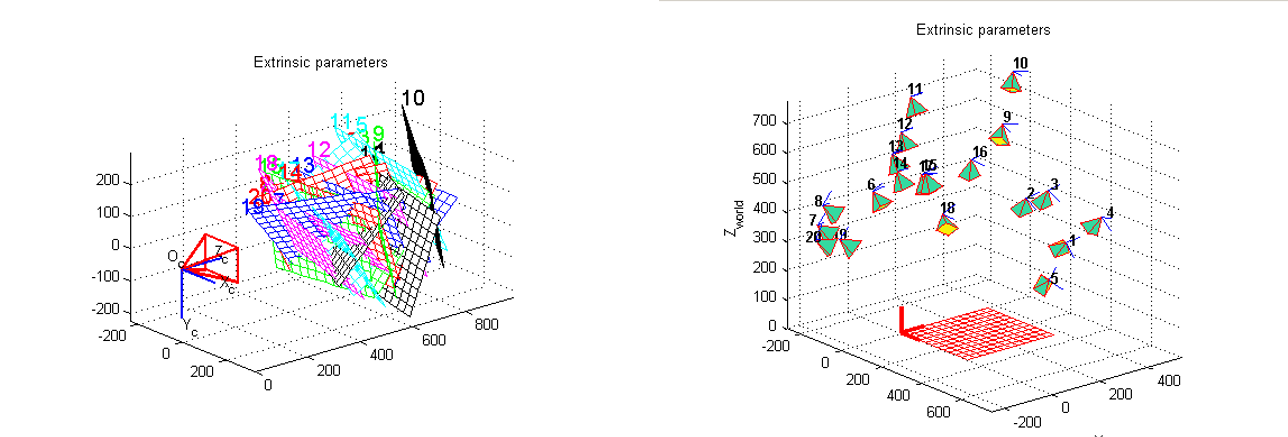

**Of course you can also move the camera to acquire the various calibration images.**

The position of the origin of the WRF on the chessboard is arbitrary, and different packages define it differently.

For instance, in OpenCV we can define two possible origins in the pattern below:

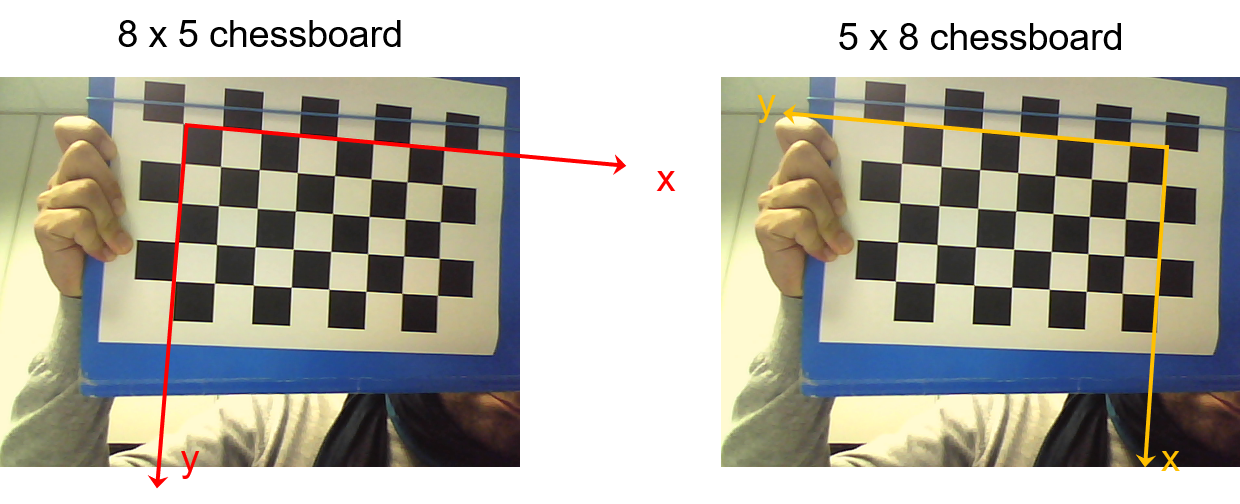

Depending on what we choose as the origin, the chessboard can be specified to the software as either $8 \times 5$ or $5 \times 8$. Note that OpenCV defines the dimensions of the chessboard as **the number of inner corners**. Once $x$ and $y$ are defined, $z$ is chosen so as to form a right-handed reference frame.

### Zhang's Method

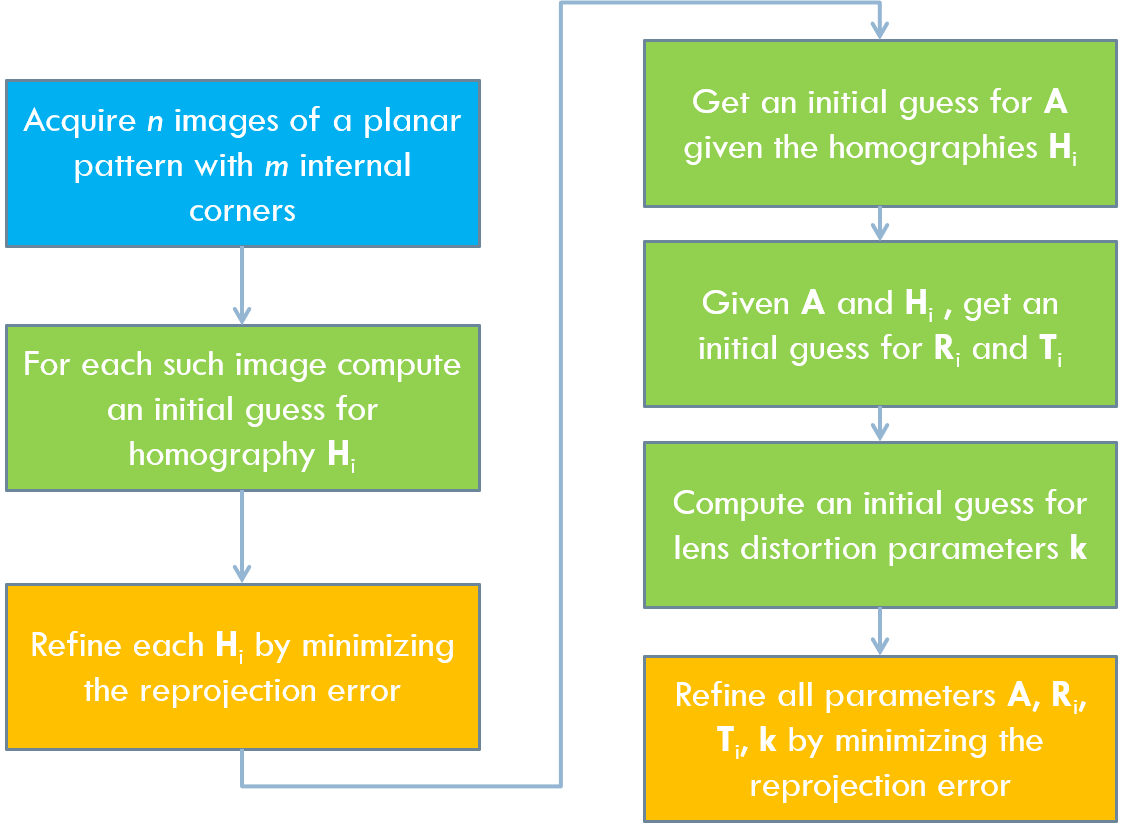

## Implementing Camera Calibration with OpenCV

First of all let us import the usual libraries:

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Acquiring the calibration images

The **minimum** number of images to calibrate a camera is **3**. A rule of thumb, however, is to take **at least 12** pictures, in order to make calibration results more robust. It is also a good idea to take pictures with **several rotations of the chessboard**.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!cp /content/drive/MyDrive/LabSessionsIPCV/lab_session_3_images.zip ./

In [ ]:
!unzip lab_session_3_images.zip
!unzip lab_session_3_images/chessboards.zip

In [ ]:
dirname = "chessboards"
img_names = [f"{dirname}/{i}.jpg" for i in range(13)]
print(img_names)

### Finding 2D-3D correspondences

First of all we need to perform the first step of Zhang's method, i.e. finding all 2D-3D correspondeces between 2D corner positions in the image and 3D world coordinates.

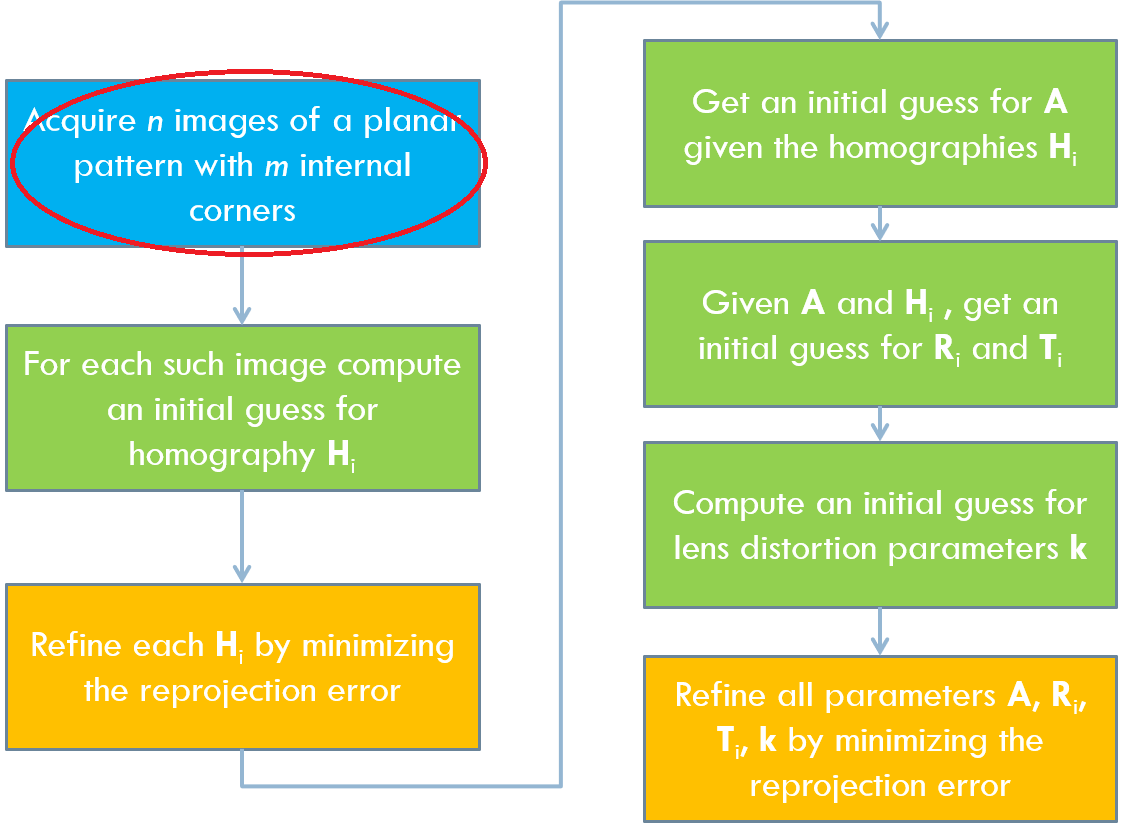

#### 2D coordinates

To find the correspondences we need to detect the corners of the chessboard image.

Let us first load a sample image to understand how to detect corners. It needs to be loaded as grayscale:

In [ ]:
img = cv2.imread("chessboards/0.jpg", cv2.IMREAD_GRAYSCALE)

Then count the number of **inner corners** per column and row of the chessboard. We will call it `pattern_size`:

In [ ]:
pattern_size = (8, 5)  # number of inner corners, expressed as (columns, rows)

We can use `cv2.findChessboardCorners(img, pattern_size)` to detect corners in an image.

The functions will return a boolean value `found` and the list of 2D coordinates of the `corners` in the image. `found` will be `True` if and only if all the $8 \times 5$ (40) corners will be detected in the image. If the image is too dark or too bright the algorithm may fail to detect corners and `found` will be false.

**Note**: if you pass the wrong `pattern_size` the method will be really slow, eventually leading to a `found==False` result.

In [ ]:
found, corners = cv2.findChessboardCorners(img, pattern_size)
print(f"Found: {found}")
print(f"2D image coordinate of corners:\n {corners}")

Even if we `found` the 2D positions of the corners, they might not be accurate.

To refine the results we can call `cv2.cornerSubPix` (see the [OpenCV documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornersubpix#cornersubpix*documentation.) for more detail about this function).

In [ ]:
# Do cornerSubPix only if chessboard found is True
if found:
    # Define corner position to subpixel iteratively until max_count=30 or criteria_eps_error=1
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    # Image corners
    cv2.cornerSubPix(img, corners, (5,5), (-1,-1), term)

Let us visualize the identified corners. Follow **from red to blu** lines to go from corner `(0,0)` to corner `(7,4)`:

In [ ]:
vis = cv2.cvtColor(cv2.resize(img, (img.shape[1]//8, img.shape[0]//8)), cv2.COLOR_GRAY2BGR)
cv2.drawChessboardCorners(vis, pattern_size, corners//8, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
corners.shape

#### 3D coordinates

We need to measure the size of the square (i.e. measure it direcly using a ruler on the printed chessboard) to know the 3D coordinates of the points:

In [ ]:
square_size = 26.5  # mm

Let us now create the 3D coordinates for each corner of the chessboard.

We know that the 3D coordinates $(x,y)$ of a corner $c_{ij}$ are $(i\,\times$ `square_size`$,j\,\times$ `square_size`$)$, where $i\in{1\ldots5} ,j\in{1\ldots8}$ are the row and column indices of the corners in the chessboard.

To build the $(i,j)$ indices for each point in the grid we can use the NumPy method `np.indices(shape)`, which returns an array containing its 2D indices:

In [ ]:
indices = np.indices(pattern_size, dtype=np.float32)
print(f"Shape of indices: {indices.shape}")
print(indices)

**Note**: we need it in `float` type because later on we will multiply it with float numbers.

Let us check for instance the indices of corner `(0,2)`  in the grid:

In [ ]:
print(indices[:,0,2])

`(0,2)` of course!

Since we know that the distance between the corners is exactly 26.5mm (`square_size`), we have to multiply these indices by `square_size` in order to get the real 3D $(x,y)$ coordinates:

In [ ]:
indices *= square_size
print(indices)

We got the $(x,y)$ coordinates of each corner in the world reference system! (assuming that the first one is in position `(0mm,0mm)`). Let us try again to print the position of corner `(0,2)`:

In [ ]:
print(indices[:,0,2])

The corner $c_{02}$ is in position `(0mm,53mm)` in the world!

Since 2D points are expressed by OpenCV as (column, row), we need to do the same for the 3D points.
Thus, we have to rearrange the 3D points by transposing the axis, i.e. the original shape `(2,8,5)` has to become `(5,8,2)`:

In [ ]:
coords_3D = np.transpose(indices, [2, 1, 0])
print(f"Transposed shape: {coords_3D.shape}")

Then, since we want a list of points, we need to reshape it to `(40,2)`:

In [ ]:
coords_3D = coords_3D.reshape(-1, 2)
print(coords_3D.shape)

In [ ]:
coords_3D[:5]

During camera calibration we will assume that the corners of the chessboard lie in the same $z=0$ plane. Thus, the $(x,y,z)$ coordinates of corner $c_{02}$ are `(0mm,53mm,0mm)`. However, `coords_3D` right now contains only the $x$ and $y$ coordinates, so we need to add a third axis $z$ of all 0s:

In [ ]:
pattern_points = np.concatenate([coords_3D, np.zeros([coords_3D.shape[0], 1], dtype=np.float32)], axis=-1)

Let us print the resulting arrays:

In [ ]:
for idx, p in enumerate(pattern_points):
    print(idx, p)

#### Repeating the process for each image
In order to perform camera calibration, we need to repeat the above operations for all calibration images. The following function takes a chessboard image as input and returns the 2D pixel coordinates of each corner:

In [ ]:
def processImage(img_name):
    print(f"Processing {img_name}")
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    # Check whether image was loaded correctly
    if img is None:
        print("Failed to load", img_name)
        return None
    # Find corners
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    if found:
        # Refine corner position
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5,5), (-1,-1), term)
        # Visualize detected corners
        vis = cv2.cvtColor(cv2.resize(img, (img.shape[1]//8, img.shape[0]//8)), cv2.COLOR_GRAY2BGR)
        cv2.drawChessboardCorners(vis, pattern_size, corners//8, found)
        plt.figure(figsize=(20,10))
        plt.imshow(vis)
        plt.show()
    else:
        print("Chessboard not found")
        return None
    print(f"{img_name} done\n")
    return corners.reshape(-1, 2)

We can now process each chessboard image previously loaded:

In [ ]:
chessboards = [processImage(name) for name in img_names]

And we filter out images where we could not detect all 40 corners:

In [ ]:
chessboards = [x for x in chessboards if x is not None]

Finally, we are ready to create two lists of 2D and 3D points, respectively, which will be used and 2D-3D correspondences during the calibration process:

In [ ]:
obj_points = []  # 3D points
img_points = []  # 2D points

for corners in chessboards:
    img_points.append(corners)
    obj_points.append(pattern_points)

### Calibrating the camera

Now that we have both 3D points (`obj_points`) and their corresponding 2D counterparts (`img_points`), we can calibrate our camera by performing the remaining Zhang's steps:
    
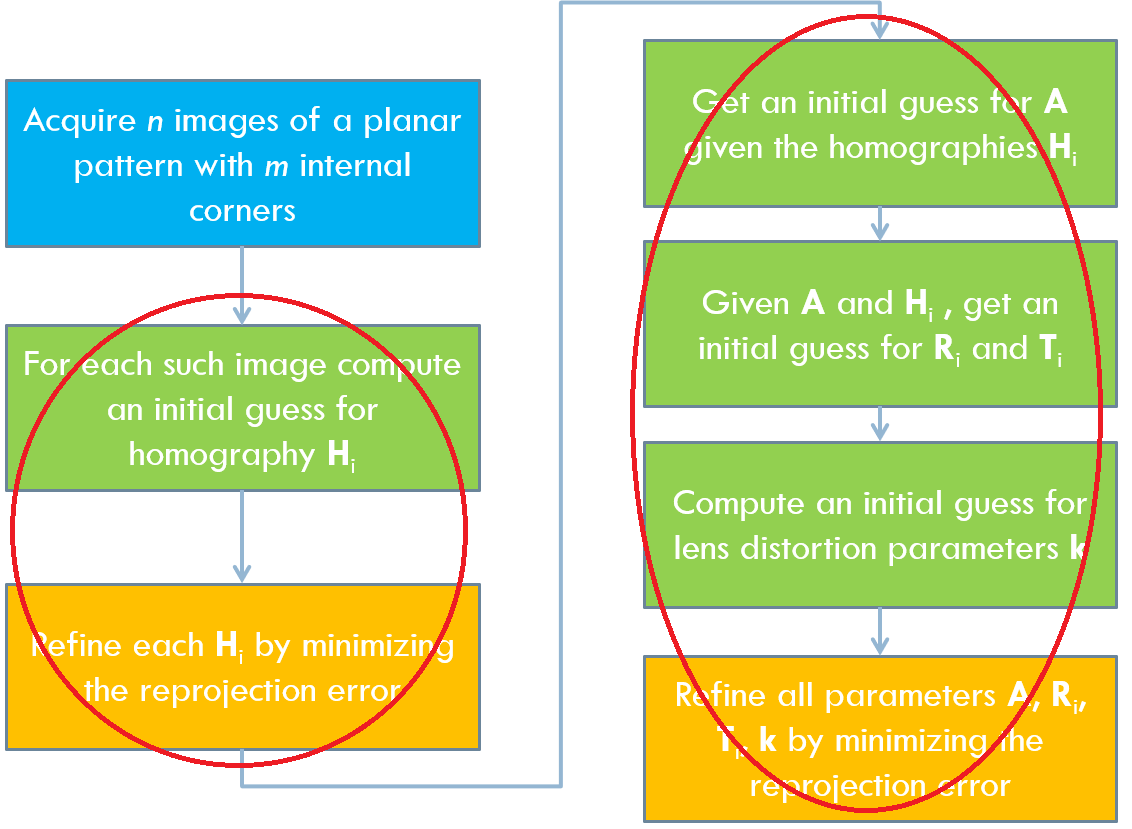

Luckily, OpenCV provides a single method to it:

`cv2.calibrateCamera(3D_points, 2D_points, (width,height), None, None)`

This method takes as input the 3D points, 2D points, width and height of the calibration images and returns all the parameters of the camera:

In [ ]:
# Get width and height of images
h, w = cv2.imread(img_names[0], cv2.IMREAD_GRAYSCALE).shape[:2]

# Calibrate camera
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

print(f"RMS: {rms}")
print(f"Camera matrix:\n{camera_matrix}")
print(f"Distortion coefficients:\n{dist_coefs.ravel()}")
print(f"Rotation vectors:\n{rvecs}")
print(f"Translation vectors:\n{tvecs}")

`cv2.calibrateCamera` produces several outputs:

* `rms` (Root Mean Squared Error): **reprojection error in pixels** using the estimated camera parameters. The lower it is, the better the calibration. It should usually be **between 0.1 and 1**. If it is much larger than 1, you made some mistakes during the calibration process;

* `camera_matrix`: **intrinsic parameters** of the camera expressed as a $3\times3$ matrix;

* `dist_coefs`: **lens distorsion** coefficents expressed as a $1\times5$ array;

* `rvecs`: **rotations** of the camera **for each chessboard image**. It is an array of dimension $N\times3$, where $N$ is the number of images where the chessboard pattern was correctly identified and 3 stands for the 3 DOF of the rotations;

* `tvecs`: **translations** of the camera **for each chessboard image**. It is an array of dimension $N\times3$, where $N$ is the number of images where the chessboard pattern was correctly identified and 3 stands for the 3 DOF of the translations.

**Note**: if we need the rotation matrix starting from a rotation vector `rvec` or vice-versa we can use `cv2.Rodrigues(rvec)`.
Given a `rvec`, it will return the corresponding $3\times3$ rotation matrix. Let us try with the first element of `rvecs` found by calibration:

In [ ]:
rotation_matrix = cv2.Rodrigues(rvecs[0])[0]
print(f"R's shape: {rotation_matrix.shape}")
print(rotation_matrix)

Therefore, if we need the complete $3\times4$ extrinsic matrix, we need to concatenate the rotation matrix and the traslation vector along axis 1:

In [ ]:
translation_matrix = tvecs[0]
print(f"T's shape: {translation_matrix.shape}")

extrinsics_matrix = np.concatenate([rotation_matrix,translation_matrix], axis=1)
print(f"RT's shape: {extrinsics_matrix.shape}")

## Undistorting images

Now that we know the **lens distorsion coefficients** and the **intrisic parameters**, we can undistort images.

**Reminder**: there are two main kind of distorsion in lenses:

* **Radial distortion**: modeled using the following relationship between the undistorted coordinates  $x_u,y_u$  and the distorted ones $x,y$:
$$x_u = x(1+k_1r_2+k_2r_4+k_3r_6)$$
$$y_u = y(1+k_1r_2+k_2r_4+k_3r_6)$$
    - **Pincushion distorsion**:
    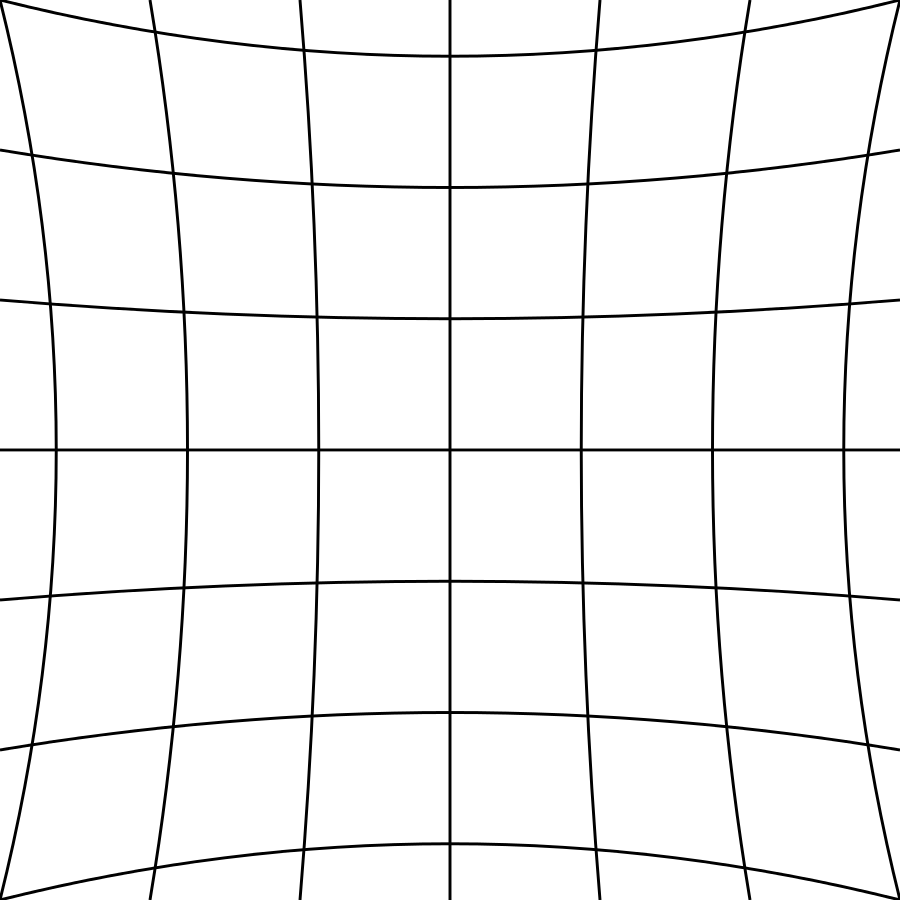
    - **Barrel distorsion**:
    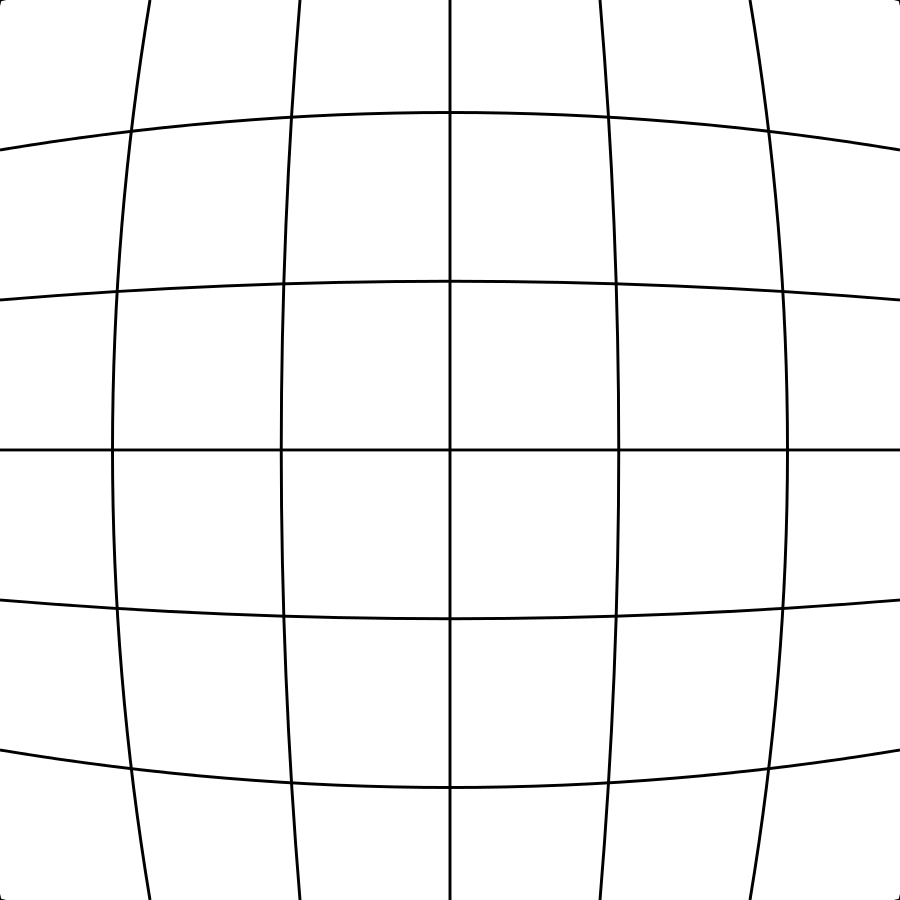
* **Tangential distortion**: occurring because the lens is not perfectly parallel to the camera plane.
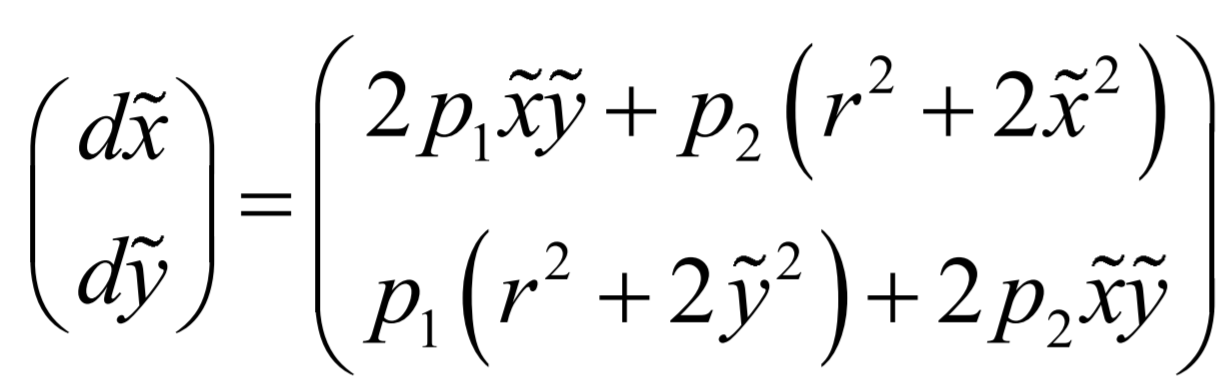

Five parameters are needed to model camera distortion: $k1,k2,k3,p1,p2$, which are the five values returned by the function `cv2.calibrateCamera` in the `dist_coefs` variable.

Two OpenCV functions allow to undistort images: `cv2.getOptimalNewCameraMatrix` and `cv2.undistort`.

In [ ]:
# Find the new optimal camera matrix
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))

img = cv2.imread("chessboards/0.jpg")
im_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

# Crop ROI
x, y, w_2, h_2 = roi
im_undistorted = im_undistorted[y:y+h_2, x:x+w_2]
plt.imshow(cv2.cvtColor(im_undistorted, cv2.COLOR_BGR2RGB))
plt.show()

## Augmented Reality

Now that we have both extrinsic and intrinsic parameters, we can project points from the 3D world to the 2D image plane.

This can be used, for instance, to implement **augmented reality** algorithms which draw 3D objects on the image. Let's see how to draw a cube on the checkerboard. First, let us define the 8  corners of a cube of side 100:

In [ ]:
_3d_corners = np.float32([[0,0,0], [0,100,0], [100,100,0], [100,0,0],
                          [0,0,-100], [0,100,-100], [100,100,-100], [100,0,-100]])

We can project points to the 2D image plane using the function `cv2.projectPoints`:

In [ ]:
image_index=0

cube_corners_2d, _ = cv2.projectPoints(
    _3d_corners,
    rvecs[image_index],
    tvecs[image_index],
    camera_matrix,
    dist_coefs)
cube_corners_2d = np.round(cube_corners_2d).astype(int)

print(cube_corners_2d) # the output consists of 8 2-dimensional points

We can now plot lines on the 3D image using the `cv2.line` function:

In [ ]:
img = cv2.imread(img_names[image_index])

# BGR colors
red = (0,0,255)
blue = (255,0,0)
green = (0,255,0)
line_width = 50

# Draw the base in red
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[1][0]), red, line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[2][0]), red, line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[3][0]), red, line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[0][0]), red, line_width)

# Draw the pillars in blue
cv2.line(img, tuple(cube_corners_2d[0][0]), tuple(cube_corners_2d[4][0]), blue, line_width)
cv2.line(img, tuple(cube_corners_2d[1][0]), tuple(cube_corners_2d[5][0]), blue, line_width)
cv2.line(img, tuple(cube_corners_2d[2][0]), tuple(cube_corners_2d[6][0]), blue, line_width)
cv2.line(img, tuple(cube_corners_2d[3][0]), tuple(cube_corners_2d[7][0]), blue, line_width)

# Draw the top in green
cv2.line(img, tuple(cube_corners_2d[4][0]), tuple(cube_corners_2d[5][0]), green, line_width)
cv2.line(img, tuple(cube_corners_2d[5][0]), tuple(cube_corners_2d[6][0]), green, line_width)
cv2.line(img, tuple(cube_corners_2d[6][0]), tuple(cube_corners_2d[7][0]), green, line_width)
cv2.line(img, tuple(cube_corners_2d[7][0]), tuple(cube_corners_2d[4][0]), green, line_width)

plt.imshow(img[...,::-1])
plt.show()

## Appendix

### $\textbf{P}$ as a homography

Due to the choice of the WRF associated with the calibration images, in each of them we only consider 3D points with $z=0$. Accordingly, the PPM boils down to a simpler transformation defined by a $3\times3$ matrix:

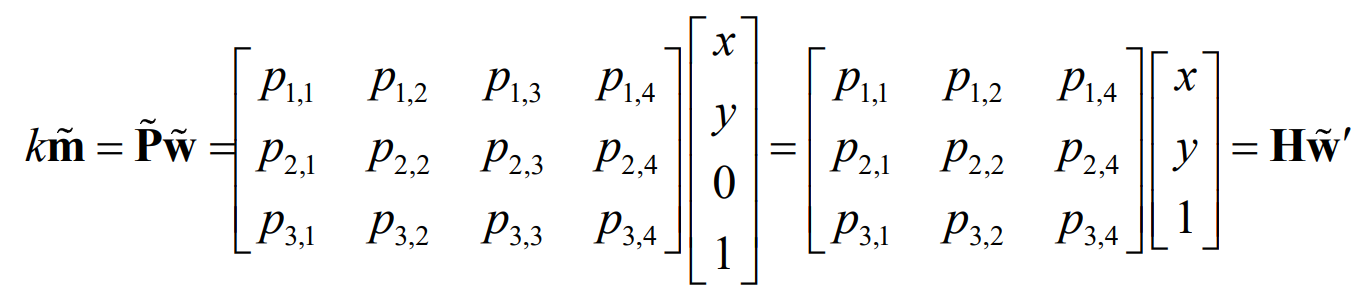

* Such a transformation, denoted here as $\textbf{H}$, is known as **homography** and represents a general linear transformation between planes. $\textbf{H}$ can be thought of as a simplification of $\textbf{P}$ when the imaged object is planar.

* Given a pattern with $m$ corners, we can write $m$ systems of 3 linear equations as above, where both 3D and 2D coordinates are known, thanks to corners having been detected in the $i$-th image, and the unknowns are therefore just the 9 elements in $\textbf{H}_i$. However, since $\textbf{H}_i$ is known up to an arbitrary scale factor (like $\textbf{P}_i$), the independent elements in $\textbf{H}_i$ are indeed just 8.

Thus, given a set of corresponding points, we may want to find the homography between them. We can do it with

`cv2.findHomography(source_points, destination_points, method)`

where:
* `source_points`: set of source points;
* `destination_points`: set of points in correspondence to `source_points` (same order as `source_points`);
* `method`: most used are `method=0` for least square optimization or `1` for RANSAC.

Otherwise, if we **only** have **4 points** we can also use

``cv2.getPerspectiveTransform(source_points, destination_points)``

In [ ]:
corners_0 = processImage(img_names[0])

In [ ]:
homography = cv2.findHomography(pattern_points[:,:2], corners_0)[0]
print(homography)

In [ ]:
points3D_4 = pattern_points[[0,10,30,39],:2].astype(np.float32)
points2D_4 = corners_0[[0,10,30,39],:2].astype(np.float32)

pt = cv2.getPerspectiveTransform(points3D_4, points2D_4)
print(pt)

### Warping
    
As we did for undistorsion, sometimes we know a mapping (e.g. homography) between points (e.g. two images) and we would like to warp an image over another. To apply a perspective transformation we can use

`cv2.WarpPerspective(src_image, tranformation_matrix, destination_shape)`

In case we want to perform the inverse trasformation, `np.linalg.inv(matrix)` can be used to calculate the inverse of a matrix.

# Now it's your turn!

## Exercise 1: 3D-2D correspondences

### Exercise 1A

Using image `chessboards/0.jpg` and the previous calibration results, find the 2D point corresponding to the 3D point `(53,53,0)` and draw a red circle around it.
Solve the exercise in two different ways:

1. Use the OpenCV function `cv2.projectPoints(object_points, rvec, tvec, camera_matrix, dist_coeffs)`;
1. Do it "manually" using the PPM matrix derived from the calibration parameters you already have.

In [ ]:
# Read the image
img = cv2.imread("chessboards/0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define the 3D point
_3d_point = np.array([[53.,53.,0.]], dtype=np.float32)

# METHOD 1: use cv2.projectPoints
# projectPoints already computes distorsion coefficients, so no need to undistort the image.
# If you still want to use the undistorted image, you have to pass newcameramtx instead of camera_matrix
# and np.array([0.,0.,0.,0.,0.]) instead of dist_coefs, since distorsion is 0 in undistorted images.
_2d_point =
_2d_point = np.round(_2d_point).astype(int)
print(f"2D point using cv2.projectPoints: {_2d_point}")

# Draw a circle around the point
img1 = np.copy(img)
cv2.circle(img1, (_2d_point[0], _2d_point[1]), 100, (255,0,0), 20)
plt.figure(figsize=(10,10))
plt.imshow(img1)
plt.show()

# METHOD 2: use the PPM
# First undistort the image to make the PPM work properly.
# You need to do it because the homography is a linear transformation and cannot remap nonlinear deformations.
newcameramtx, roi =
img_undistorted =

# Compute the PPM components: A,R and T
R =
T =
A = # you are using the undistorted image, hence you need to use the new optimal A

# Build the PPM
PPM =

# Define the 3D point in homogeneous coordinates in order to multiply it with the PPM
_3d_point_homogeneous =

# Multiply it with the PPM to obtain the pixel in homogeneous coordinates
_2d_point_homogeneous =

# Divide it by its third value to get the pixel coordinate
_2d_point =
_2d_point = np.round(_2d_point).astype(int)

print(f"\n2D point using PPM: {int(round(_2d_point[0,0])), int(round(_2d_point[1,0]))}")

# Draw the point
img2 = np.copy(img_undistorted)
cv2.circle(img2, (_2d_point[0][0], _2d_point[1][0]), 100, (255,0,0), 20)

# Crop away the black region obtained by undistorting
img2 = img2[y:y+h_2, x:x+w_2]

plt.figure(figsize=(10,10))
plt.imshow(img2)
plt.show()

### Exercise 1B

Find the 3D point corresponding to the 2D point of corner `(2,2)`. Do it first using a new homography (calculated with `cv2.findHomography`) and then using the PPM derived from the calibration parameters.

The expected result is approximately `(53,53,0)`.

In [ ]:
# Read the image
img = cv2.imread("chessboards/0.jpg")

# METHOD 1: use cv2.findHomography
# Undistort the image to make the PPM work properly
newcameramtx, roi =
img =

# Build chessboard 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0] * pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:,:2] = coords_3D

def processImage(img):
    # processImage takes the undistorted image in this case
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print("Chessboard not found")
        return None

    return corners.reshape(-1, 2)

corners = processImage(img)

# Get the position of corner (2,2)
_2d_point = # corner (2,2) 2D position
_2d_point_homogeneous =

# Find the homography between 3D points and 2D points
homography = cv2.findHomography(pattern_points, corners, 0)[0]

# Use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous =

# Transform homogeneous coordinates into Euclidean coordinates
_3d_point =

# Force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print(f"3D point using new homography: {_3d_point[0]}")

# METHOD 2: use the PPM
R =
T =
A = # you are using the undistorted image, hence you need to use the new optimal A

# Build the PPM
PPM =

# P as a homography
homography =

# Use the inverse of the homography to project the 2D point to the 3D point
_3d_point_homogeneous =

# Transform homogeneous coordinates into Euclidean coordinates
_3d_point =

# Force the 3D point to be on the chessboard plane
_3d_point[-1] = 0.

_3d_point = _3d_point.reshape([1,3])
print(f"\n3D point using PPM: {_3d_point[0]}")

## Exercise 2: 3D Measureaments in mm

Take an image with an object belonging to same plane of the chessboard. In our case, it will be `ex2/pen.jpg`. Measure the lenght of that object in mm. Image coordinates are provided for you.

Expected_results: `145.56mm`.

**Tips**:
* Find the homography given 2D-3D correspondences;
* Get the coordinates of two pixels of the object;
* Apply the same transformation as in Exercise 1B to get the 3D coordinates of those pixels;
* Find the Euclidean distance between two 3D points to get your measurements.

In [ ]:
# Distorsion will be ignored in this exercise

img_name = "lab_session_3_images/ex2/pen.jpg"
img = cv2.imread(img_name)

# Build 3D points
indices = np.indices(pattern_size, dtype=np.float32)
indices *= square_size
pattern_points = np.zeros([pattern_size[0] * pattern_size[1], 3], np.float32)
coords_3D = indices.T.reshape(-1, 2)
pattern_points[:, :2] = coords_3D

def processImage(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    found, corners = cv2.findChessboardCorners(img, pattern_size)

    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    else:
        print("Chessboard not found")
        return None

    return corners.reshape(-1, 2)

# Build 2D-3D correspondeces
corners = processImage(img_name)

# Find homography between the two sets of points
homography = cv2.findHomography(pattern_points, corners)[0]  # from 3D to 2D

# 2D points A,B
point2D_homogeneous_a = (2722, 1160, 1)
point2D_homogeneous_b = (2686, 2675, 1)

# Find 3D coordinates
point3D_homogeneous_a =
point3D_a =
point3D_a[-1] = 0

point3D_homogeneous_b =
point3D_b =
point3D_b[-1] = 0

# Draw line and circles
cv2.circle(img, (point2D_homogeneous_a[0], point2D_homogeneous_a[1]), 100, (0,0,255), 5)
cv2.circle(img, (point2D_homogeneous_b[0], point2D_homogeneous_b[1]), 100, (0,0,255), 5)
cv2.line(
    img,
    (point2D_homogeneous_a[0], point2D_homogeneous_a[1]),
    (point2D_homogeneous_b[0], point2D_homogeneous_b[1]),
    (0,255,0), 10)

dist =
print(f"Distance: {dist:.2f}mm")

plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Try this at home

## Exercise 3: Augmented Reality

Given an image, project it on the chessboard to cover all the corners of the image. Try to restore the values of the original image (the one with the chessboard) instead of the black pixels obtained with warping.
Image coordinates are provided for you.

Test the algorithm on `ex3/chessboard.jpg` and `ex3/stregatto.jpg`.

**Tips**:
* Find the perspective transformation;
* Warp the image;
* Understand what are the points to restore to the original values;
* Restore the values in those pixels;

In [ ]:
# Distorsion will be ignored in this exercise

image = cv2.imread("lab_session_3_images/ex3/chessboard.jpg")
image2project = cv2.imread("lab_session_3_images/ex3/stregatto.jpg")

h, w = image.shape[0], image.shape[1]
h_2, w_2 = image2project.shape[0], image2project.shape[1]

# Coordinates of the chessboard perimeter
rect = np.array([
    [2537, 519],
    [2573, 3480],
    [530, 3670],
    [488, 380]], dtype="float32")

# Coordinates of the border of the image we want to project
src =

# Compute the perspective transformation matrix
M =

# Apply the transformation matrix
warped =

# Warp a white mask to understand which pixels are black
white = np.ones([h_2, w_2, 3], dtype=np.uint8) * 255
warp_mask = cv2.warpPerspective(white, M, (w,h))
warp_mask = np.equal(warp_mask, np.array([0,0,0]))

# Restore previous values
warped[warp_mask] = image[warp_mask]

# Display original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Display warped image
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()